### Answers to Assignment 2 of 230E

##### Authors(alphabetic order)
1) Ishan Pathak ishan_pathak@berkeley.edu
2) Leonid Maksymenko leo.maksymenko@berkeley.edu
3) Nymph Qiu nymph_qiu@berkeley.edu
4) Xuanzhong Ren rxz19@berkeley.edu

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,chi2, t

### Q1

#### (a)

Model satisfy the assumptions of the classical OLS models. Because classical OLS has more strict requirements, asymptotic OLS assumptions would also be satisfied.<br>
**Classical homoskedastic linear regression model** is good in this case given exogeneity, normality and homoskedasticity holds.<br>
1)Because $x,\epsilon \sim i.i.d.N(0,1)$, strict exogeneity holds. 
$$E(\epsilon|X)=0$$
2)And homoskedasticity of residuals holds given $\epsilon$ is i.i.d<br>
$\hat{\beta}$ is the best unbiased linear predictor.<br>
$$\hat{\beta}=(X'X)^{-1}X'y=\frac{\sum_{i=1}^T y_ix_i}{\sum_{i=1}^T x_i^2}$$
$$E(\hat{\beta}-\beta|X)=E((X'X)^{-1}X'\epsilon|X)=0$$
And it follows the distribution as below.
$$\hat{\beta} - \beta|X \sim N(0, \frac{1}{\sum_{i=1}^T x_i^2})$$
Theoretical standard error is $\frac{1}{\sqrt{\sum_{i=1}^T x_i^2}}$ given X. As for unconditional variance <br>
$$Var(\hat{\beta})=E((\hat{\beta} - \beta)^2)=E(((\hat{\beta} - \beta)^2|X))=E(\frac{1}{\sum_{i=1}^T x_i^2})=\frac{1}{T-2}$$

#### (b)

In [2]:
N = 10000
Ts = [20, 50, 100, 500]
betas = {T: [] for T in Ts}
beta_vars = {T: [] for T in Ts}
for T in Ts:
    for i in range(N):
        X = np.random.normal(0,1,T).reshape(T,1)
        e = np.random.normal(0,1,T).reshape(T,1)
        y = X+e
        betas[T].append(np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)),X.T), y)[0,0])
        beta_vars[T].append(np.linalg.inv(np.dot(X.T, X))[0,0])

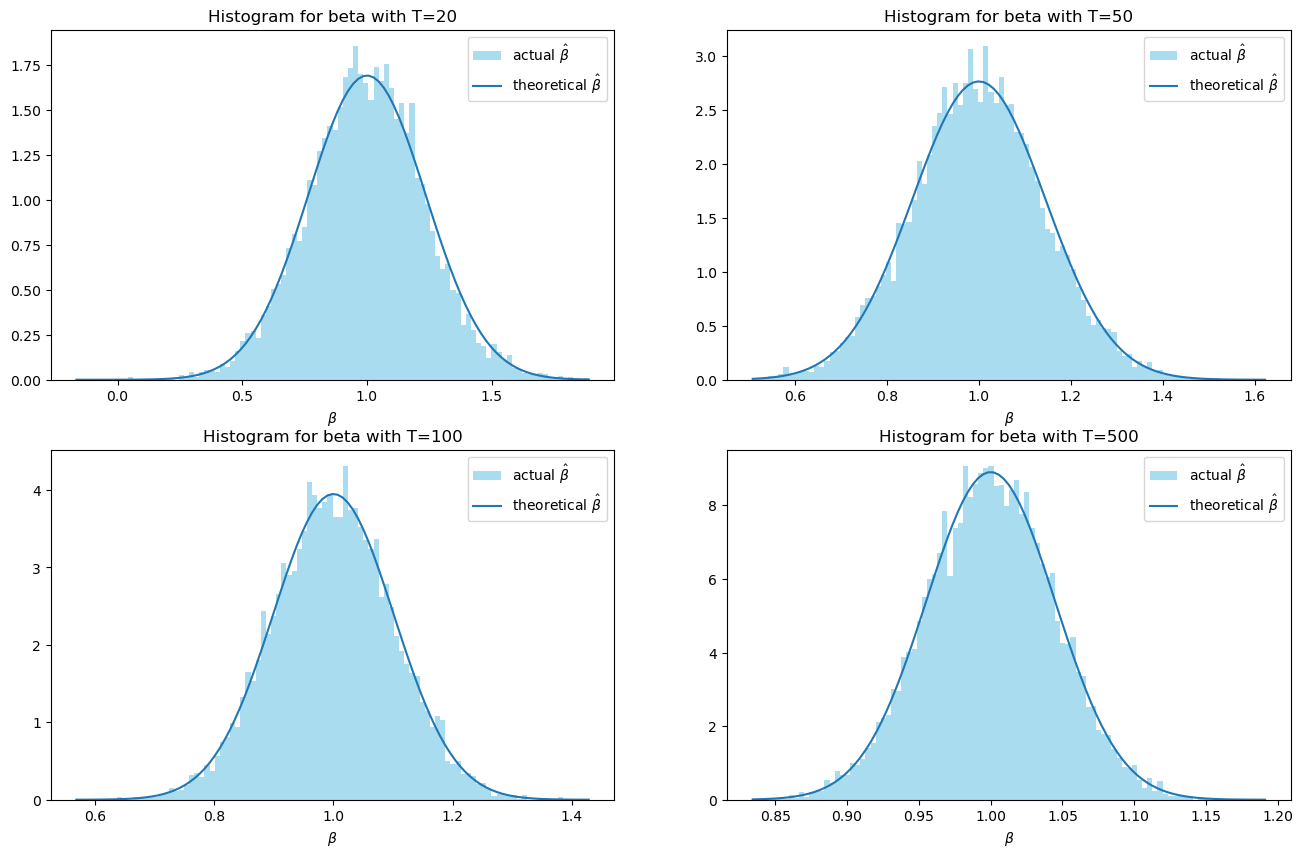

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
for i in range(4):
    T = Ts[i]
    n, bins, patches = axes[i//2,i%2].hist(betas[Ts[i]], 100, density = 1,color ='skyblue',alpha = 0.7, label=r'actual $\hat{\beta}$')
    expected_var = np.mean(beta_vars[Ts[i]])
    y_T = 1/np.sqrt(2*np.pi/(T-2))*np.exp(-(bins-1)**2/2*(T-2))
    axes[i//2,i%2].plot(bins, y_T, label=r'theoretical $\hat{\beta}$')
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_xlabel(r'$\beta$')
    axes[i//2,i%2].set_title(f'Histogram for beta with T={Ts[i]}')

We could observe that the actual distribution of $\beta$ is close to theoretical normal distribution.

### Q2

#### (a)

In [4]:
import pandas_datareader.data as web
start = '1953-4-1'
today = '2020-2-29'
GS10 = web.DataReader(['GS10'], 'fred', start, today).dropna()

In [34]:
def plot_series(y,diff=0):
    plt.figure(figsize=(10,6))
    if diff==0:
        plt.plot(y)
        plt.title(f'10-year Treasury yield series')
        return y
    else:
        y_diff=np.empty((len(y),diff+1))
        y_diff.fill(np.nan)
        y_diff[:,0]=y
        for i in range(1,diff+1,1):
            y_diff[i:,i]=y_diff[i:,i-1]-y_diff[i-1:-1,i-1]
        plt.plot(y_diff[diff:,diff])
    plt.title(f'10-year Treasury yield series, differenced {diff} time(s)')
    return y_diff[diff:,diff]

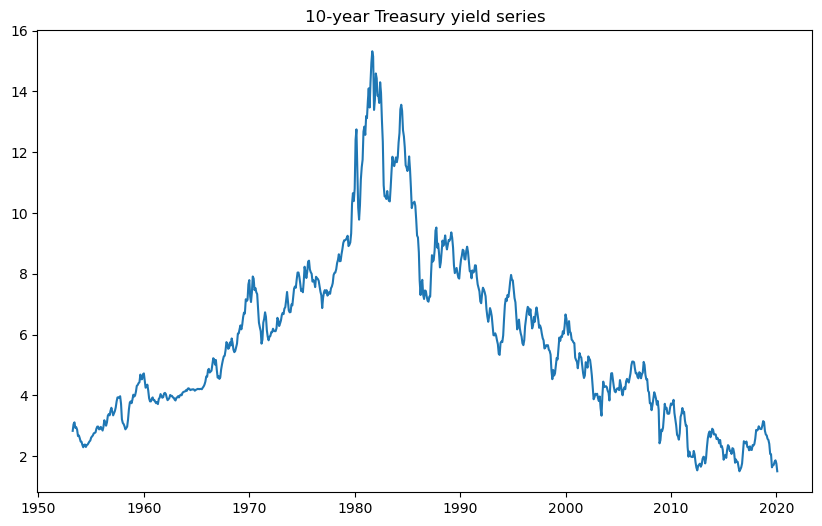

In [35]:
_=plot_series(GS10.GS10,0)

From the plot for rates series above we conclude that there is a strong persistence in time series for 10-year treasury yields, indicates presence of autocorrelation. Further the series seems non stationary over the time period as there is little evidence for mean reversion

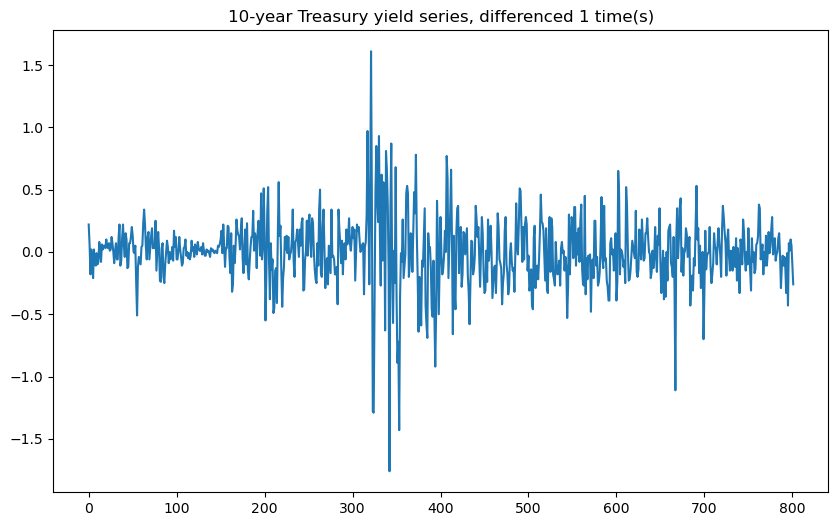

In [36]:
_=plot_series(GS10.GS10,1)

From the plot for rates series differenced 1 time, we see lower persistence than difference=0, and the series looks stationary. However the variance of the series does not seem const. over time

#### (b)

In [46]:
def lag_mat(y,nlags,fill_value=np.nan):
    y_lags=np.empty((y.shape[0],nlags+1))
    y_lags.fill(fill_value)
    y_lags[:,0]=y
    
    for i in range(1,nlags+1):
        y_lags[i:,i]=y[:-i]
        
    return y_lags

def calc_ols2(x,y,addconst=True):
    nobs=x.shape[0]
    if addconst:
        x=np.hstack([np.ones((nobs,1)),x])
    X_t_X = np.dot(x.T,x)
    X_t_Y = np.dot(x.T,y)
    beta_hat = np.linalg.solve(X_t_X,X_t_Y)
    residuals = y-np.dot(x,beta_hat)
    return beta_hat,residuals,x

def calc_pacf(y,nlags):
    
    y_lags=lag_mat(y,nlags)
    pacfs=[0]
    # calc pacf from 1 to nlags
    for i in range(1,nlags+1,1):
        beta_hat,residuals,x = calc_ols2(y_lags[i:,1:i+1],y_lags[i:,0])
        pacfs.append(beta_hat[-1])
    #y,y_1,y_2,y_3,y_4,y_5
    return pacfs
    
    
def calc_acf(y,nlags):
    acfs = [1]
    y_lag = lag_mat(y,nlags)
    # calc acf from lags=1 to nlags
    for lag in range(1,nlags+1):
        beta,residuals,x = calc_ols2(y_lag[lag:,lag].reshape(-1,1),y_lag[lag:,0])
        acfs.append(beta[-1])
    return acfs

def plotacf(y,nlags):
    acf = np.array(calc_acf(y,nlags))
    plt.figure(figsize=(10,6))
    up=[0]
    for i in range(1,nlags+1,1):
        up.append(norm.ppf(0.975,scale=1,loc=0)*np.sqrt((1+2*np.sum(acf[1:i]**2))/(len(y[i:]))))
    dwn = [-x for x in up]
    plt.fill_between(range(1+nlags),up,dwn,color='grey', alpha=0.5)
    plt.bar(range(1+nlags),acf,width=0.2)
    plt.title(f'Autocorrelation plot for {nlags} lags')
    
def plotpacf(y,nlags):
    acf = np.array(calc_pacf(y,nlags))
    plt.figure(figsize=(10,6))
    up=[0]
    for i in range(1,nlags+1):
        up.append(norm.ppf(0.975,scale=1,loc=0)*np.sqrt(1/(len(y[i:]))))
    dwn = [-x for x in up]
    plt.fill_between(range(1+nlags),up,dwn,color='grey', alpha=0.5)
    plt.bar(range(1+nlags),acf,width=0.09)
    plt.title(f'Partial Autocorrelation plot for {nlags} lags')

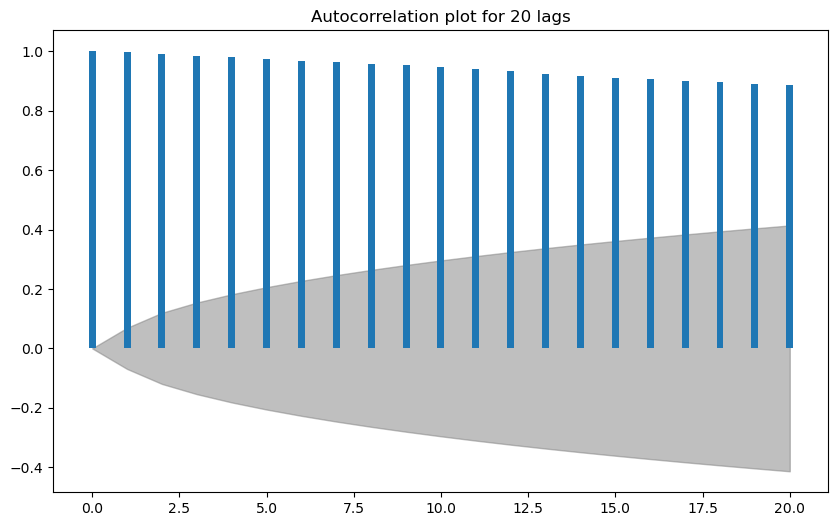

In [47]:
# ACF plot for rates series
_=plotacf(GS10.GS10,20)

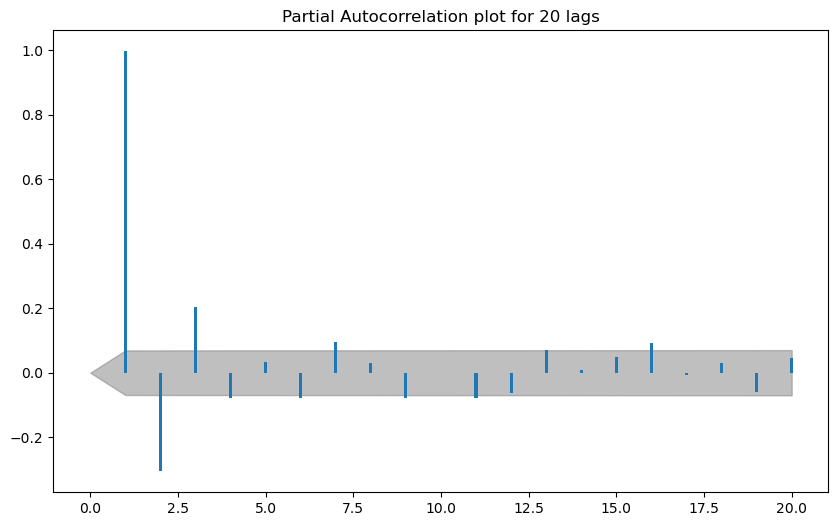

In [48]:
plotpacf(GS10.GS10,20)

We could observe that the time series is not ergodic given ACF cannot die out for large lags so there is little chance for mean reversion and stationarity. As for PACF, we could see that large lags still persist, which further supports that data is not ergodic.

#### (c)

In [88]:
def calc_ols(y, lags=1):
    y_lags = []
    for i in range(lags):
        y_lags.append(y[i:len(y)-(lags-i)])
    y_lags = np.array(y_lags).T
    y_ = np.array(y[lags:]).reshape(len(y_lags),1)
    y_lags = np.concatenate((np.ones((len(y_lags), 1)), y_lags), axis=1)
    coef = np.dot(np.dot(np.linalg.inv(np.dot(y_lags.T, y_lags)),y_lags.T),y_)
    residual = y_ - np.dot(y_lags, coef)
    r_squared = np.sum((np.dot(y_lags, coef) - np.mean(y_))**2)/np.sum((y_ - np.mean(y_))**2)
    var = np.sum(residual**2)/(len(y_)-(lags+1))
    hetero_var = np.dot(y_lags.T, np.dot(np.diag(np.diag(np.dot(residual,residual.T))),y_lags))
    nw_var = hetero_var
    for i in range(lags):
        for j in range(i+1, len(y_)):
            part1 = y_lags[j].reshape(lags+1,1)
            part2 = y_lags[j-i-1].reshape(lags+1,1)
            nw_var = nw_var + 2*(1-(i+1)/(1+lags))*np.dot(part1, part2.T)*(residual[j][0]*residual[j-i-1][0])
    beta_homo_var = np.linalg.inv(np.dot(y_lags.T, y_lags))*var
    lhs = np.linalg.inv(np.dot(y_lags.T, y_lags))
    beta_hetero_var = np.dot(np.dot(lhs, hetero_var), lhs.T)
    beta_nw_var = np.dot(np.dot(lhs, nw_var), lhs.T)
    data = {"type": [],"coef":[], "homo_std":[],"hetero_std":[],"nw_std":[],"p-val(nw cov)":[],"t-stat":[]}
    for i in range(lags+1):
        if i == 0:
            data["type"].append("mu")
        else:
            data["type"].append(f"phi{lags+1-i}")
        data["coef"].append(coef[i,0])
        data["homo_std"].append(np.sqrt(beta_homo_var[i][i]))
        data["hetero_std"].append(np.sqrt(beta_hetero_var[i][i]))
        data["t-stat"].append(coef[i,0]/np.sqrt(beta_nw_var[i][i]))
        data["p-val(nw cov)"].append(2-2*t.cdf(abs(coef[i,0])/np.sqrt(beta_nw_var[i][i]), df=len(y_) - lags - 1))
        data["nw_std"].append(np.sqrt(beta_nw_var[i][i]))
    log_likelihood = -0.5*np.log(2*np.pi)*len(y_) - (len(y_)-(lags+1))/2 - 0.5 * len(y_) * np.log(var)
    AIC = -2*log_likelihood + 2 * (lags+1)
    BIC = -2*log_likelihood + np.log(len(y_)) * (lags+1)
    DW = np.sum((residual[1:]-residual[:-1])**2)/np.sum((residual[1:])**2)
    return pd.DataFrame(data=data), r_squared, AIC, BIC, log_likelihood, DW

**AR(1) Model: $x_t = \mu + \phi_1x_{t−1} + \epsilon_t$**

In [89]:
params, r_squared, AIC, BIC, log_likelihood, DW = calc_ols(GS10["GS10"], lags=1)
display(params)
display(pd.DataFrame(data={"type":["r^2","AIC","BIC","log likelihood","DW-stat"],"value":[r_squared,AIC, BIC, log_likelihood, DW]}))

,type,coef,homo_std,hetero_std,nw_std,p-val(nw cov),t-stat
0,mu,0.018857,0.021046,0.026955,0.029968,0.529365,0.629250
1,phi1,0.996438,0.003272,0.005508,0.006175,0.000000,161.358833


,type,value
0,r^2,0.991446
1,AIC,149.386513
2,BIC,158.760730
3,log likelihood,-72.693256
4,DW-stat,1.391309


**AR(2) Model:** $x_t = \mu + \phi_1x_{t−1} + \phi_2x_{t−2} + \epsilon_t$

In [90]:
params, r_squared, AIC, BIC, log_likelihood, DW = calc_ols(GS10["GS10"], lags=2)
display(params)
display(pd.DataFrame(data={"type":["r^2","AIC","BIC","log likelihood","DW-stat"],"value":[r_squared,AIC, BIC, log_likelihood, DW]}))

,type,coef,homo_std,hetero_std,nw_std,p-val(nw cov),t-stat
0,mu,0.027009,0.020106,0.026466,0.024823,2.769014e-01,1.088050
1,phi2,-0.305585,0.033737,0.054676,0.045871,5.035017e-11,-6.661881
2,phi1,1.300634,0.033718,0.053560,0.044469,0.000000e+00,29.248361


,type,value
0,r^2,0.992241
1,AIC,73.182454
2,BIC,87.240037
3,log likelihood,-33.591227
4,DW-stat,1.873826


#### (d)

In [59]:
print("AR(1) root(s):", 1/0.996438)
print("AR(2) root(s):", \
      (1.300634 + np.sqrt(1.300634**2-4*0.305585))/2/0.305585,
     (1.300634 - np.sqrt(1.300634**2-4*0.305585))/2/0.305585
     )

AR(1) root(s): 1.0035747331996572
AR(2) root(s): 3.249006277435143 1.0072039423073185


AR(1): $x_t = 0.018857 + 0.996438x_{t−1} + \epsilon_t$. The root is 1.0035747331996572<br>
AR(2): $x_t = 0.027009 + 1.300634x_{t−1} -0.305585x_{t−2} + \epsilon_t$. The roots are 3.249006277435143 and 1.0072039423073185<br>

#### (e)

AR(1) IRF

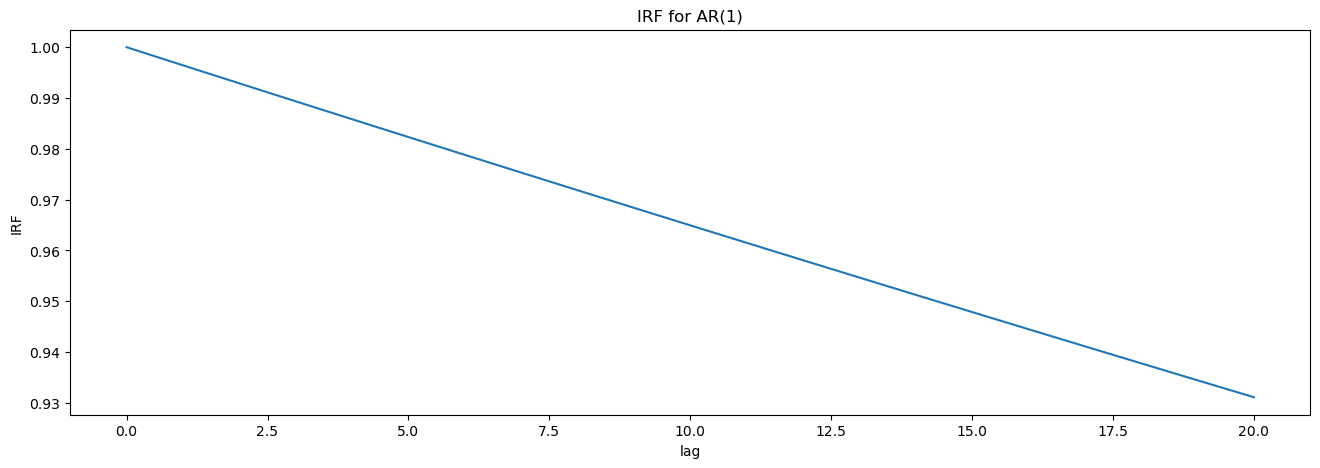

In [60]:
phi1 = 0.996438
irf_ar1 = [phi1**i for i in range(21)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.plot(list(range(21)), irf_ar1)
axes.set_xlabel("lag")
axes.set_ylabel("IRF")
axes.set_title("IRF for AR(1)")
plt.show()

AR(2) model<br>
$x_t(1-\frac{1}{3.249006277435143}L)(1-\frac{1}{1.0072039423073185
}L)=0.027009 + \epsilon_t$<br>
$x_t=(0.027009 + \epsilon_t)(\frac{a}{1-\frac{1}{3.249006277435143}L}+\frac{b}{1-\frac{1}{1.0072039423073185
}L})$<br>
=>$a=-0.4492831176616153, b=1.4492831176616152$

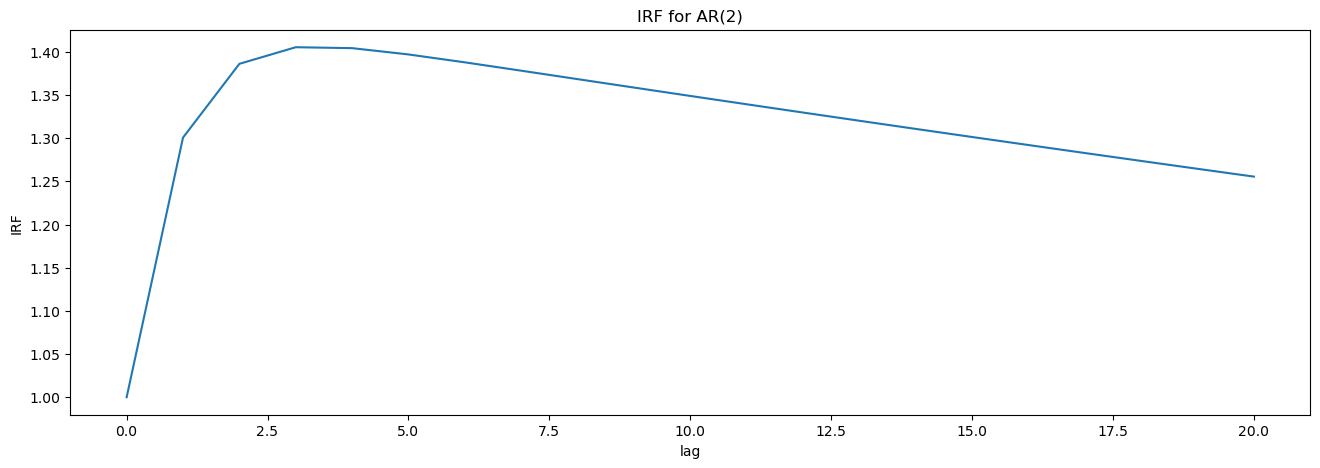

In [61]:
a = -0.4492831176616153
b = 1.4492831176616152
lambda1 = 1/3.249006277435143
lambda2 = 1/1.0072039423073185
irf_ar2 = [a*lambda1**i + b*lambda2**i for i in range(21)]
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
axes.plot(list(range(21)), irf_ar2)
axes.set_xlabel("lag")
axes.set_ylabel("IRF")
axes.set_title("IRF for AR(2)")
plt.show()

#### (f)

Based on AIC and BIC along with $R^2$, we could observe that AR(2) works better. And according to t tests, lag 1 and lag 2 are significant at 5% level. And ACF shows high serial correlation between lags and it cannot die out for large lags which implies the need for more lags in the AR models.

## Q3

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
data=pd.read_csv('GS10.csv')
data.set_index('DATE',inplace=True)

#### (a)

In [63]:
def ols(y,x):
    if x.shape[1]==0:
        x=np.ones(len(y)).reshape(-1,1)
    else:
        x=np.hstack((np.ones((len(x),1)),x))
    beta=np.linalg.inv(x.T@x)@x.T@y
    y_hat = x @ beta
    residuals = y - y_hat
    n = len(y)
    k = x.shape[1]
    sigma2 = np.sum(residuals**2) / (n - k)
    var_beta_homoskedastic = sigma2 * np.linalg.inv(x.T @ x)
    weight_matrix = np.diagflat(residuals**2)
    var_beta_heteroskedastic = np.linalg.inv(x.T @ x) @ (x.T @ weight_matrix @ x) @ np.linalg.inv(x.T @ x)
    RSS = np.sum(residuals**2)
    AIC = 2 * k + n * np.log(RSS / n)
    BIC = k * np.log(n) + n * np.log(RSS / n)
    R_squared = 1 - RSS / np.sum((y - np.mean(y))**2)
    return beta, var_beta_homoskedastic, var_beta_heteroskedastic,AIC,BIC,R_squared


In [64]:
data.index=pd.to_datetime(data.index)

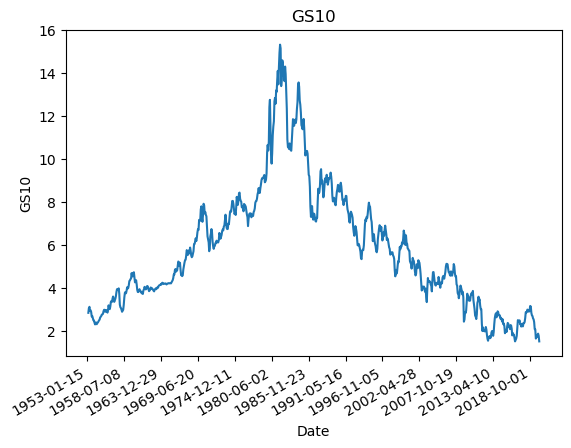

In [65]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(data.index, data['GS10'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2000))
ax.set_xlabel('Date')
ax.set_ylabel('GS10')
plt.title('GS10')
plt.gcf().autofmt_xdate()
plt.show()

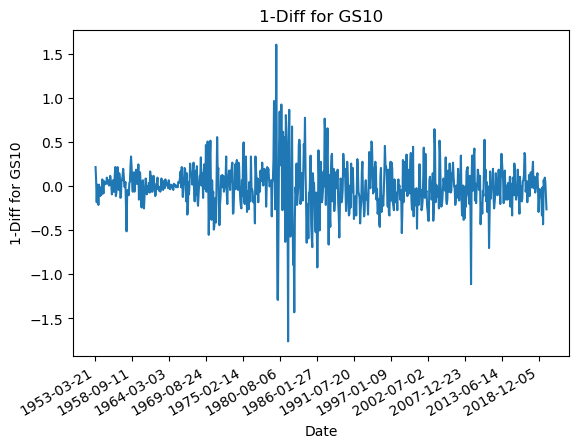

In [66]:
data['diff']=data['GS10'].diff()
fig, ax = plt.subplots()
ax.plot(data.index, data['diff'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2000))
ax.set_xlabel('Date')
ax.set_ylabel('1-Diff for GS10')
plt.title('1-Diff for GS10')
plt.gcf().autofmt_xdate()
plt.show()

In [67]:
def create_adf_lag(x,lag):
    X=np.zeros((len(x)-lag-1,lag+1))
    X[:,0]=x[lag:len(x)-1]
    delta_x=x[1:]-x[:-1]
    for i in range(1,lag+1):
        X[:,i]=delta_x[lag-i:len(delta_x)-i]
    return X

In [68]:

def adf_test(x,max_lag,diff_lag):
    ADF_result=pd.DataFrame(index=range(max_lag+1),columns=['beta','var_beta_homoskedastic','var_beta_heteroskedastic','AIC','BIC',\
'R_squared','1% critical value','5% critical value','10% critical value','t value'])
    x=np.diff(x,diff_lag)
    for lag in range(max_lag+1):
        X=create_adf_lag(x,lag)
        delta_x=x[1:]-x[:-1]
        if lag==0:
            y=delta_x
        else:
            y=delta_x[lag:]
        beta,var_beta_homoskedastic,var_beta_heteroskedastic,AIC,BIC,R_squared=ols(y,X)
        critical_values=adfuller(x,autolag='AIC',regression='c',maxlag=lag)[4]
        t_value=beta[1]/np.sqrt(var_beta_homoskedastic[1,1])
        ADF_result.loc[lag]=np.hstack((beta[1],var_beta_homoskedastic[1,1],var_beta_heteroskedastic[1,1],AIC,BIC,R_squared,\
                                    critical_values['1%'],critical_values['5%'],critical_values['10%'],t_value))
    return ADF_result


In [69]:
x=np.array(data['GS10'])
diff_x=np.diff(x)
res=adf_test(x,max_lag=15,diff_lag=1)
res

,beta,var_beta_homoskedastic,var_beta_heteroskedastic,AIC,BIC,R_squared,1% critical value,5% critical value,10% critical value,t value
0,-0.697217,0.001137,0.002893,-2199.44677,-2190.075048,0.34853,-3.43854,-2.865155,-2.568695,-20.675043
1,-0.841857,0.001676,0.004162,-2228.86843,-2214.814595,0.376349,-3.438551,-2.86516,-2.568697,-20.562606
2,-0.777314,0.002557,0.006154,-2228.090953,-2209.357509,0.379798,-3.438561,-2.865164,-2.5687,-15.372321
3,-0.804573,0.003321,0.00782,-2223.392566,-2199.982023,0.380335,-3.438561,-2.865164,-2.5687,-13.960888
4,-0.743317,0.004124,0.008315,-2222.445434,-2194.360306,0.384017,-3.438581,-2.865173,-2.568705,-11.575479
5,-0.816594,0.004785,0.010325,-2224.891944,-2192.13475,0.390237,-3.438592,-2.865178,-2.568707,-11.805454
6,-0.84254,0.005644,0.01354,-2219.995383,-2182.568646,0.390527,-3.438592,-2.865178,-2.568707,-11.215422
7,-0.77812,0.006525,0.014281,-2219.028405,-2176.934654,0.394141,-3.438613,-2.865187,-2.568712,-9.632703
8,-0.780151,0.007326,0.016855,-2213.321857,-2166.563625,0.394222,-3.438613,-2.865187,-2.568712,-9.114555
9,-0.722504,0.008091,0.017257,-2211.800717,-2160.380542,0.397421,-3.438634,-2.865196,-2.568717,-8.032422


We find that the original T-bill yield is not stationary, however, if we can diff the data once, the sequence is stationary since the p-value is lower than 0.01

#### (b)

In [70]:
def create_ar_lag(x,lag):
    X=np.zeros((len(x)-lag,lag))
    for i in range(1,lag+1):
        X[:,i-1]=x[lag-i:len(x)-i]
    return X
def ar(x,ar_lags):
    ar_result=pd.DataFrame(index=ar_lags,columns=['R2','AIC','BIC'])
    for lag in ar_lags:
        if lag==0:
            y=x
        else:
            y=x[lag:]
        X=create_ar_lag(x,lag)
        beta,var_beta_homoskedastic,var_beta_heteroskedastic,AIC,BIC,R_squared=ols(y,X)
        ar_result.loc[lag]=np.hstack((R_squared,AIC,BIC))
    return ar_result
ar_res=ar(diff_x,ar_lags=range(1,11))


In [71]:
ar_res

,R2,AIC,BIC
1,0.091649,-2199.44677,-2190.075048
2,0.13066,-2228.86843,-2214.814595
3,0.135613,-2228.090953,-2209.357509
4,0.136796,-2223.392566,-2199.982023
5,0.141941,-2222.445434,-2194.360306
6,0.150132,-2224.891944,-2192.13475
7,0.151103,-2219.995383,-2182.568646
8,0.156149,-2219.028405,-2176.934654
9,0.156089,-2213.321857,-2166.563625
10,0.160652,-2211.800717,-2160.380542


I choose AR(2) since it has the minimum AIC and BIC simultaneously and the rsquare is also great.

#### (c)

The T-bill data is stationary after 1-order diffencing. And the AR(2) process is proper for the model choice.

## Q4

#### (a)

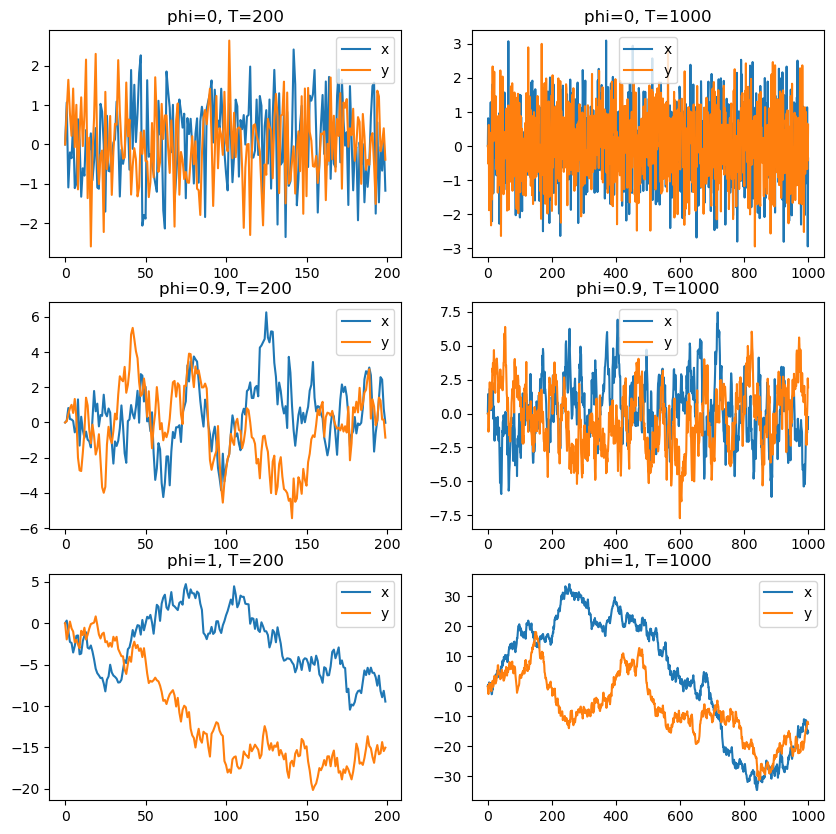

In [72]:
def simulate_ar1_ols(phi, T):
    epsilon = np.random.normal(0, 1, T)
    eta = np.random.normal(0, 1, T)
    
    y = np.zeros(T)
    x = np.zeros(T)
    for t in range(1, T):
        y[t] = phi * y[t-1] + epsilon[t]
        x[t] = phi * x[t-1] + eta[t]
    return x,y
fig,ax=plt.subplots(3,2,figsize=(10,10))
phi=[0,0.9,1]
T=[200,1000]
for index,i in enumerate(phi):
    for col,j in enumerate(T):
        x,y=simulate_ar1_ols(i,j)
        ax[index,col].plot(x,label='x')
        ax[index,col].plot(y,label='y')
        ax[index,col].set_title('phi='+str(i)+', T='+str(j))
        ax[index,col].legend()
    


#### (b)

In [73]:
for index,i in enumerate(phi):
    for col,j in enumerate(T):
        x,y=simulate_ar1_ols(i,j)
        beta,var_beta_homoskedastic,var_beta_heteroskedastic,AIC,BIC,R_squared=ols(y.reshape(-1,1),x.reshape(-1,1))
        print('phi='+str(i)+', T='+str(j)+'\n')
        res=pd.Series([beta[1][0],var_beta_homoskedastic[1,1],var_beta_heteroskedastic[1,1],AIC,BIC,R_squared],\
            index=['beta','var_beta_homoskedastic','var_beta_heteroskedastic','AIC','BIC','R_squared'])
        print(res)
        print('\n')
        

phi=0, T=200

beta                        -0.035259
var_beta_homoskedastic       0.004858
var_beta_heteroskedastic     0.004743
AIC                          6.639707
BIC                         13.236342
R_squared                    0.001291
dtype: float64


phi=0, T=1000

beta                         0.002945
var_beta_homoskedastic       0.001044
var_beta_heteroskedastic     0.001038
AIC                         13.033717
BIC                         22.849228
R_squared                    0.000008
dtype: float64


phi=0.9, T=200

beta                          0.065944
var_beta_homoskedastic        0.003067
var_beta_heteroskedastic      0.002415
AIC                         259.916214
BIC                         266.512849
R_squared                     0.007110
dtype: float64


phi=0.9, T=1000

beta                           0.003645
var_beta_homoskedastic         0.001545
var_beta_heteroskedastic       0.001545
AIC                         1872.714216
BIC                         1882.5297

#### (c)

In [74]:
import copy
null_col= {col: [[] for _ in range(3)] for col in range(2)}
betas=pd.DataFrame(null_col)
t_stats=pd.DataFrame(copy.deepcopy(null_col))
R_squareds=pd.DataFrame(copy.deepcopy(null_col))
num=10000
for _ in range(num):
    for index,i in enumerate(phi):
        for col,j in enumerate(T):
            x,y=simulate_ar1_ols(i,j)
            beta, var_beta, _, _, _, R_squared = ols(y.reshape(-1,1), x.reshape(-1,1))
            beta_hat = beta[1,0]
            se = np.sqrt(var_beta[1, 1])
            t_stat = beta_hat / se
            betas.loc[index,col].append(beta_hat)
            t_stats.loc[index,col].append(t_stat)
            R_squareds.loc[index,col].append(R_squared)

phi=0, T=200



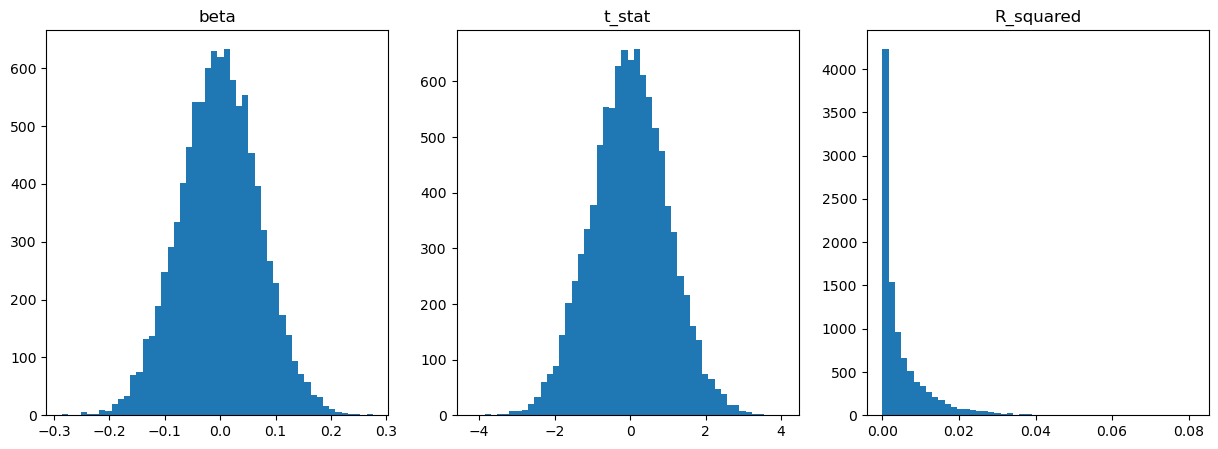

phi=0, T=1000



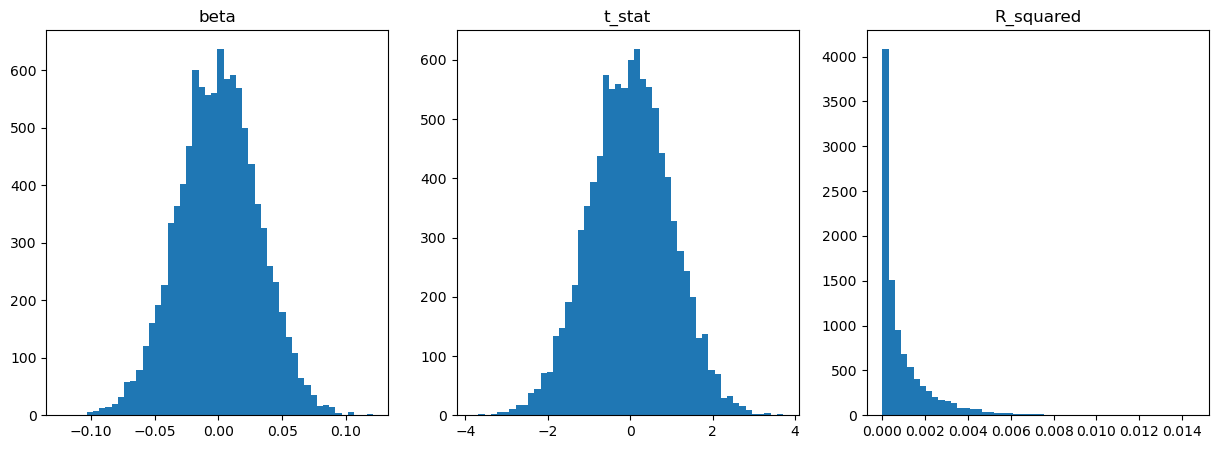

phi=0.9, T=200



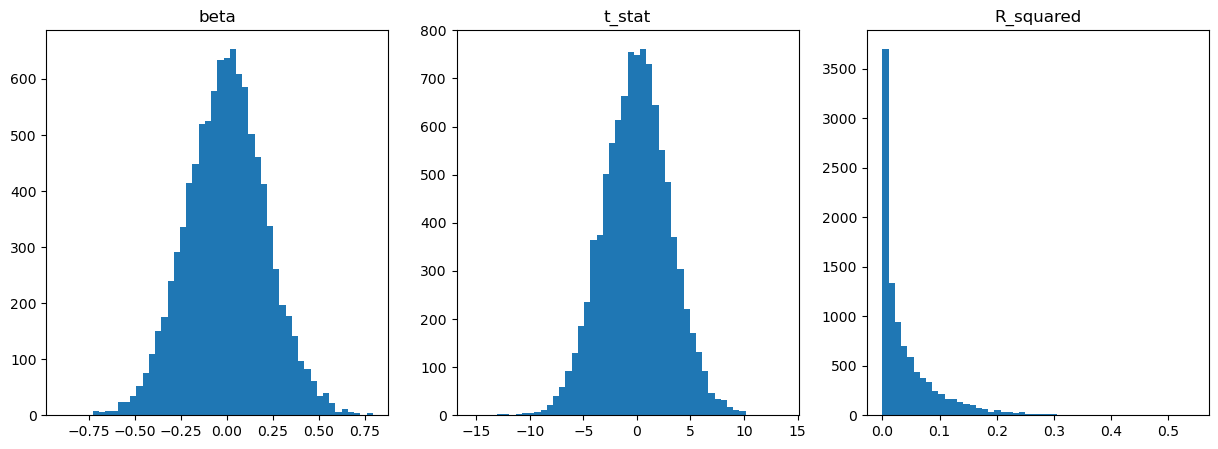

phi=0.9, T=1000



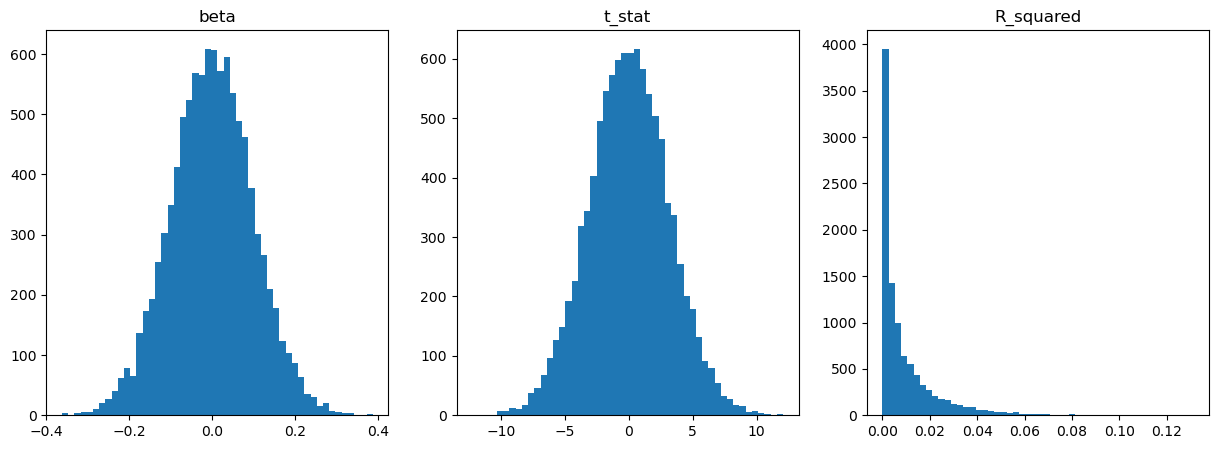

phi=1, T=200



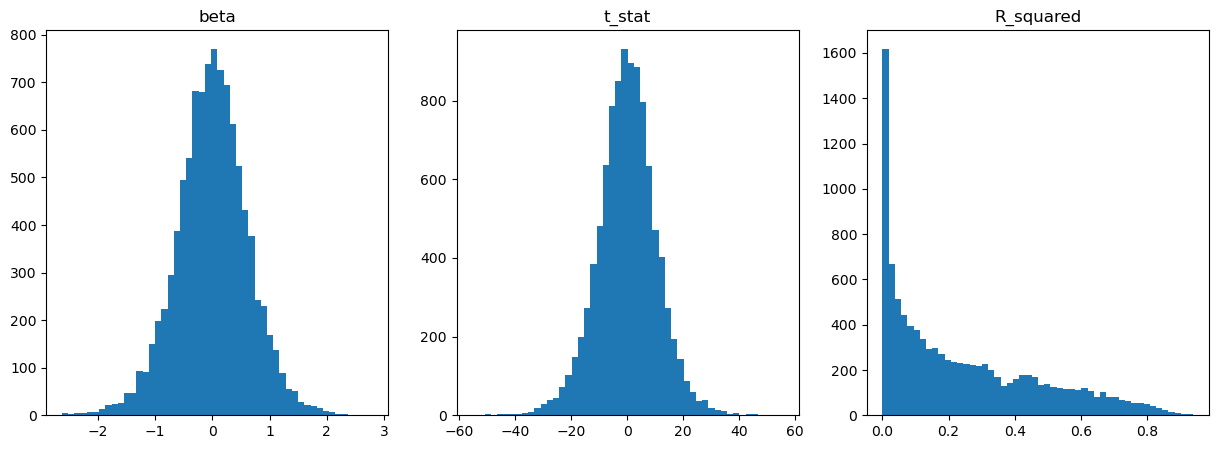

phi=1, T=1000



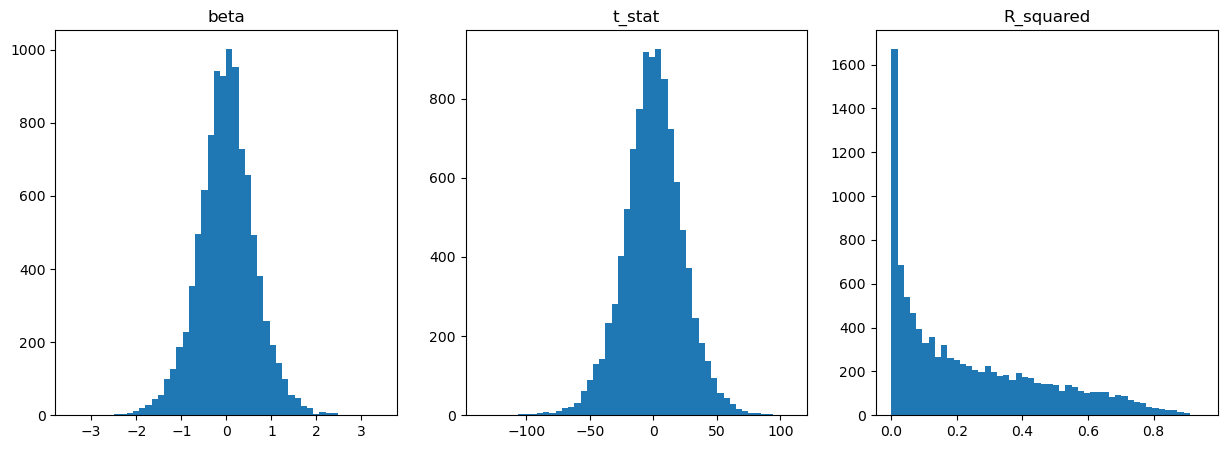

In [75]:
for index,i in enumerate(phi):
    for col,j in enumerate(T):
        print('phi='+str(i)+', T='+str(j)+'\n')
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].hist(betas.loc[index,col],bins=50)
        ax[0].set_title('beta')
        ax[1].hist(t_stats.loc[index,col],bins=50)
        ax[1].set_title('t_stat')
        ax[2].hist(R_squareds.loc[index,col],bins=50)
        ax[2].set_title('R_squared')
        plt.show()


#### (e)

In [76]:
from scipy.stats import t
critical=pd.DataFrame(index=[200,1000],columns=[0.01,0.05,0.1])
for col,j in enumerate(T):
    for alpha in [0.01,0.05,0.1]:
        critical.loc[j,alpha]=t.ppf(1-alpha/2,j-2)


In [77]:
rej_percentage=pd.DataFrame(index=[0,0.9,1],columns=[200,1000])
for index,i in enumerate(phi):
    for col,j in enumerate(T):
        t_stat=t_stats.loc[index,col]
        rej_percentage.loc[i,j]=[np.sum(np.abs(t_stat)>critical.loc[j,0.01])/10000,np.sum(np.abs(t_stat)>critical.loc[j,0.05])/10000,\
        np.sum(np.abs(t_stat)>critical.loc[j,0.1])/10000]


In [78]:
rej_percentage

,200,1000
0.0,"[0.01, 0.0503, 0.1018]","[0.0095, 0.0472, 0.0978]"
0.9,"[0.3995, 0.5199, 0.5874]","[0.4034, 0.5312, 0.5984]"
1.0,"[0.7863, 0.8371, 0.8622]","[0.9063, 0.9277, 0.9391]"


In usual, the rejection percentage should be near to the confidence level under large samples.

#### (f)

Given $\phi$, the higher the T is, the more possible it may refuse H0
Given T, the higher the $\phi$ is, the more possible it may refuse H0